In [1]:
from faqer.services.classificator.eval import NavecDistCalculator, IOWDistCalculator, RDTModel
from faqer.services.data.utils import get_lines, get_text, tokenize_text, get_trigrams

In [2]:
rdt_calc = RDTModel()

[2020-12-30 15:01:53,042] [INFO] loading projection weights from /home/artkra/SOURCES/faqer/models/rdt/all.norm-sz100-w10-cb0-it1-min100.w2v
[2020-12-30 15:02:01,218] [WARNING] duplicate word '……………………………………………………………………………………' in word2vec file, ignoring all but first
[2020-12-30 15:02:01,452] [INFO] duplicate words detected, shrinking matrix size from 1239965 to 1239964
[2020-12-30 15:02:01,453] [INFO] loaded (1239964, 100) matrix from /home/artkra/SOURCES/faqer/models/rdt/all.norm-sz100-w10-cb0-it1-min100.w2v
[2020-12-30 15:02:01,454] [INFO] precomputing L2-norms of word weight vectors


In [726]:
%%time 

from gensim.summarization import keywords

text = ''
for line in get_lines():
    if '?' in line:
        text += line
kwds = set(keywords(text).split())

CPU times: user 32.5 s, sys: 12.7 s, total: 45.2 s
Wall time: 9.2 s


In [727]:
%%time

from scipy.spatial.distance import pdist
from numpy import ndarray
import statistics

res = []

custom_stopwords = ['http', 'https', 'это']

trigram_vectors = []
trigrams = []


for line in get_lines():
    if '?' not in line:
        continue
    tokens = tokenize_text(line, do_stem=False)
    tokens = [t for t in tokens if t in kwds]
#     tokens = [t for t in tokens if t not in custom_stopwords]
    dists = []
    
    for input_trigram in get_trigrams(tokens):
        for sent_trigram in get_trigrams(sent_tokens):
            sum1 = sum([rdt_calc.w2v.word_vec(w) for w in sent_trigram if w in rdt_calc.w2v.vocab])
            sum2 = sum([rdt_calc.w2v.word_vec(w) for w in input_trigram if w in rdt_calc.w2v.vocab])
            if isinstance(sum1, ndarray) and isinstance(sum2, ndarray):
                trigram_vectors.append(sum2)
                trigrams.append(input_trigram)
                dists += [pdist([sum1, sum2])]

    if len(dists):
        dist = statistics.median([d.mean() for d in dists])
        res.append((line, dist))
            
    

CPU times: user 20.8 s, sys: 1.59 s, total: 22.3 s
Wall time: 22.4 s


In [728]:
len(trigram_vectors)

17747

In [730]:
%%time
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

X = trigram_vectors
# X = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.99, min_samples=19).fit(X)

labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_
        

CPU times: user 18.9 s, sys: 23.6 s, total: 42.6 s
Wall time: 6.27 s


3

In [731]:
from collections import Counter
from statistics import mean

clusters_summary = []
for c in range(n_clusters_): 
    clust_words = Counter()
    for i, k in enumerate(dbscan.labels_):
        if k==c:
            clust_words += Counter([x for x in trigrams[i]])
    mean_freq = mean(list(clust_words.values()))
    clusters_summary.append([w for w in clust_words.keys() if clust_words[w] > mean_freq])

In [732]:
clusters_summary[1:]

[['тикет', 'https', 'это'], ['нужно', 'кому', 'обратиться', 'подскажите']]

In [713]:
# 0.99 15

In [723]:
from statistics import mean

def predict_cat(sentence):
    dists = []
    for i, summary in enumerate(clusters_summary):
        clust_dists = []
        for word in tokenize_text(sentence, do_stem=False):
            for kwrd in summary:
                dist = rdt_calc.dist_words(word, kwrd)
                if dist:
                    clust_dists.append(dist)
        dists.append((i, mean(clust_dists)))
    return dists

In [724]:
predict_cat('можно, пожалуйста, получить доступ')

[(0, 0.6413111973221547),
 (1, 0.5503824452559153),
 (2, 0.6289453506469727),
 (3, 0.5853347107768059),
 (4, 0.545369052224689),
 (5, 0.5227172300219536),
 (6, 0.6448385914166769),
 (7, 0.5252452835440635),
 (8, 0.5938576087355614),
 (9, 0.5256103393104341),
 (10, 0.609868818273147)]

In [737]:
set().union(*clusters_summary)

{'aborted',
 'access',
 'account',
 'active',
 'add',
 'address',
 'agent',
 'allowed',
 'amp',
 'api',
 'app',
 'apr',
 'apt',
 'artifactory',
 'auth',
 'authentication',
 'authorization',
 'authorized',
 'available',
 'aws',
 'bad',
 'bidswitch',
 'bionic',
 'bit',
 'bot',
 'branch',
 'bsw',
 'build',
 'bytes',
 'certificate',
 'change',
 'changed',
 'changes',
 'changeset',
 'changesets',
 'channel',
 'check',
 'cipher',
 'client',
 'code',
 'commit',
 'config',
 'configuration',
 'confluence',
 'connect',
 'connection',
 'create',
 'created',
 'crucible',
 'curl',
 'cvs',
 'dashboard',
 'data',
 'default',
 'denied',
 'devops',
 'diff',
 'directory',
 'disappointed',
 'disk',
 'docker',
 'documentation',
 'email',
 'end',
 'error',
 'errors',
 'exists',
 'expected',
 'failed',
 'failure',
 'file',
 'files',
 'following',
 'forbidden',
 'frontend',
 'git',
 'gitlab',
 'gmail',
 'google',
 'gpg',
 'graphite',
 'guys',
 'help',
 'hook',
 'host',
 'http',
 'https',
 'idm',
 'image',
 '

In [589]:
from statistics import mean

for i in range(n_clusters_):
    print(mean(list(clusters_summary[i].values())))



13.021954674220963
3.1153846153846154
3.096774193548387
4.695652173913044
3.6666666666666665


CPU times: user 53.4 ms, sys: 32.3 ms, total: 85.7 ms
Wall time: 19.2 ms


1

In [670]:
import nltk
'что' in nltk.corpus.stopwords.words('russian')

True

543 такую 6
564 эту 6
983 какую 6
1033 одну 6
1214 свою 6
1504 которую 6
1552 новую 6


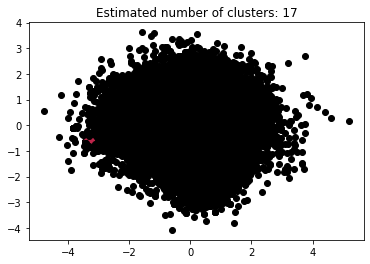

In [6]:
import matplotlib.pyplot as plt
import numpy as np

n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [7]:
n_clusters_

17

In [8]:
import copy

def label_line(line):
    db = copy.deepcopy(db)
    sumnew = sum([rdt_calc.w2v.word_vec(w) for w in line if w in rdt_calc.w2v.vocab])
    if isinstance(sumnew, ndarray):
        data = StandardScaler().fit_transform([sumnew])
        return db.fit_predict(data)[0]
    return -1

In [9]:
# for line in get_lines():
#     if '?' not in line:
#         continue
#     tokens = tokenize_text(line, do_stem=False)
    
#     for input_trigram in get_trigrams(tokens):
#         try:
#             label = label_line(input_trigram)
#             if label.mean() > -1:
#                 print(line, label)
#         except Exception:
#             pass

In [1]:
# list(filter(lambda x: x >0, aff.labels_))